# Image Classification with Malaria Dataset: Training a CNN and Converting to TensorFlow Lite
Name : Diandra R. A. Damanik

Dicoding Username : diandra_regita

Email : diandraregita14@gmail.com

In [3]:
!pip install kaggle

### Import necessary libraries

In [50]:
import os
import random
import shutil
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import nltk
import re
import string
import zipfile

from PIL import Image
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, LearningRateScheduler
from keras.optimizers import Adam, SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [4]:
from google.colab import drive
drive.mount('/content/drive')

os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/kaggle'

Mounted at /content/drive


In [30]:
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria

 98% 664M/675M [00:10<00:00, 111MB/s] 
100% 675M/675M [00:10<00:00, 65.1MB/s]


Unzip the file to a specific destination

In [32]:
with zipfile.ZipFile('cell-images-for-detecting-malaria.zip', 'r') as zip_ref:
    zip_ref.extractall('/content')

### Check image resolutions

In [56]:
def get_image_resolution(image_path):
    with Image.open(image_path) as img:
        return img.size

def check_image_resolutions(folder_path):
    resolutions = set()

    for subdir, dirs, files in os.walk(folder_path):
        for file in files:
            if file.lower().endswith(('.png')):
                image_path = os.path.join(subdir, file)
                resolution = get_image_resolution(image_path)
                resolutions.add(resolution)

    if len(resolutions) > 1:
        print("Resolutions are different:")
        for res in resolutions:
            print(res)
        return False

    print("Resolutions are consistent:", resolutions.pop())
    return True

In [55]:
base_path = 'dataset'

result = check_image_resolutions(base_path)

Resolutions are different:
(166, 181)
(124, 184)
(130, 115)
(88, 118)
(139, 163)
(199, 214)
(205, 145)
(97, 166)
(163, 148)
(121, 151)
(196, 181)
(94, 133)
(154, 184)
(193, 175)
(157, 109)
(127, 166)
(187, 217)
(190, 142)
(109, 154)
(127, 202)
(148, 145)
(160, 199)
(142, 187)
(181, 178)
(145, 112)
(238, 160)
(103, 115)
(160, 91)
(118, 94)
(178, 145)
(136, 148)
(142, 79)
(100, 82)
(151, 127)
(130, 190)
(169, 181)
(175, 112)
(133, 115)
(226, 163)
(91, 118)
(163, 223)
(202, 214)
(106, 97)
(166, 148)
(226, 199)
(124, 151)
(130, 82)
(88, 85)
(139, 130)
(97, 133)
(157, 184)
(163, 115)
(121, 118)
(172, 163)
(196, 148)
(94, 100)
(154, 151)
(172, 199)
(112, 154)
(94, 136)
(127, 133)
(187, 184)
(112, 190)
(145, 187)
(109, 121)
(127, 169)
(148, 112)
(145, 223)
(184, 151)
(142, 154)
(181, 145)
(142, 190)
(103, 82)
(175, 187)
(115, 172)
(136, 115)
(208, 220)
(151, 94)
(58, 52)
(130, 157)
(169, 148)
(133, 82)
(205, 187)
(130, 193)
(91, 85)
(241, 289)
(202, 181)
(205, 223)
(166, 115)
(124, 118)
(139,

### Create Train-Validation Split

In [38]:
image_paths = []
labels = []

for label in os.listdir(base_path):
    label_path = os.path.join(base_path, label)
    if os.path.isdir(label_path):
        for image_name in os.listdir(label_path):
            image_path = os.path.join(label_path, image_name)
            image_paths.append(image_path)
            labels.append(label)

train_paths, val_paths, train_labels, val_labels = train_test_split(
    image_paths, labels, test_size=0.2, random_state=42, stratify=labels
)

### Create Directories for Train and Validation Data

In [39]:
train_dir = 'train_data'
val_dir = 'val_data'

for label in set(labels):
    os.makedirs(os.path.join(train_dir, label), exist_ok=True)
    os.makedirs(os.path.join(val_dir, label), exist_ok=True)

### Move Images to Respective Directories

In [40]:
def move_images(image_paths, labels, destination_dir):
    for image_path, label in zip(image_paths, labels):
        destination_path = os.path.join(destination_dir, label, os.path.basename(image_path))
        shutil.copy(image_path, destination_path)

move_images(train_paths, train_labels, train_dir)
move_images(val_paths, val_labels, val_dir)

### Data Generation

In [41]:
img_width, img_height = 32, 32
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 22046 images belonging to 2 classes.
Found 5512 images belonging to 2 classes.


### Defining the CNN model architecture

In [46]:
model = Sequential([
    Conv2D(32, (3, 3), input_shape=(img_width, img_height, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(len(train_generator.class_indices), activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Training the model

Define callbacks

In [47]:
early_stopping = EarlyStopping(monitor='val_accuracy',
                               patience=3,
                               verbose=1)

In [48]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=50,
    validation_data=val_generator,
    callbacks=[early_stopping]
)

Epoch 1/50
688/688 [==============================] - 47s 65ms/step - loss: 0.4223 - accuracy: 0.7911 - val_loss: 0.2010 - val_accuracy: 0.9351
Epoch 2/50
688/688 [==============================] - 43s 62ms/step - loss: 0.2013 - accuracy: 0.9285 - val_loss: 0.1675 - val_accuracy: 0.9492
Epoch 3/50
688/688 [==============================] - 43s 62ms/step - loss: 0.1770 - accuracy: 0.9401 - val_loss: 0.1610 - val_accuracy: 0.9459
Epoch 4/50
688/688 [==============================] - 48s 70ms/step - loss: 0.1650 - accuracy: 0.9443 - val_loss: 0.1543 - val_accuracy: 0.9537
Epoch 5/50
688/688 [==============================] - 46s 66ms/step - loss: 0.1589 - accuracy: 0.9459 - val_loss: 0.1647 - val_accuracy: 0.9510
Epoch 6/50
688/688 [==============================] - 42s 60ms/step - loss: 0.1534 - accuracy: 0.9474 - val_loss: 0.1597 - val_accuracy: 0.9516
Epoch 7/50
688/688 [==============================] - 41s 60ms/step - loss: 0.1470 - accuracy: 0.9503 - val_loss: 0.1539 - val_accuracy:

### Model Evaluation and Visualization

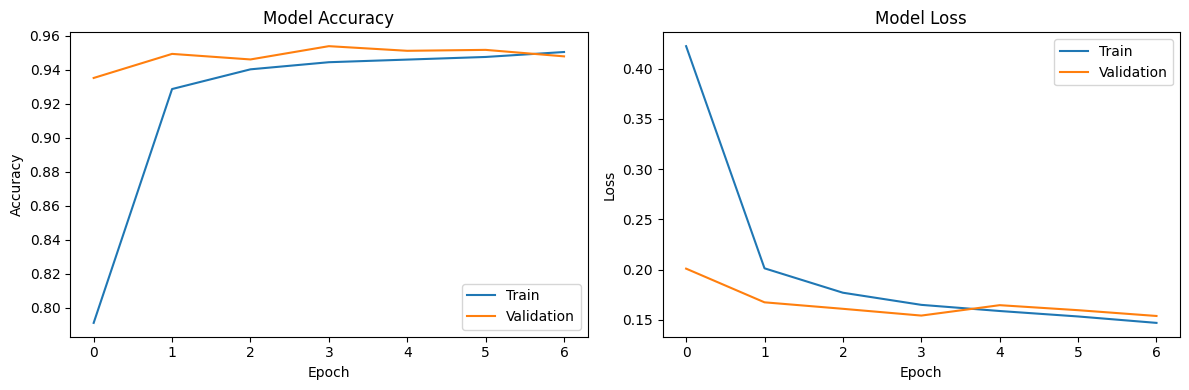

In [49]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

### Convert the Keras model to TF-Lite format

In [52]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

print("TF-Lite model has been successfully saved to 'model.tflite'")

TF-Lite model has been successfully saved to 'model.tflite'
